# Word2Vec : Creating Word Embeddings with Pytorch

## Implementing the CBOW model

Using text from Shakespeare's plays, we will implement the CBOW model from scratch, using pytorch to simplify the creation of the network architecture and training loop. The implementation will be divided into 4 parts: 
* **Building the corpus Vocab**
* **Create the (context_window, target_word) examples**
* **Build the neural network architecture**
* **Train the model**
* **Visualize the word embeddings**

### 1. Building the corpus Vocab

In [6]:
import nltk
from nltk.tokenize import word_tokenize
import re  


# import txt corpus
with open('corpus/Shakespeare_small.txt') as f:
    text = f.read()   
text = re.sub(r'[,!?;-]', '.',text)                                 #  Punktuations are replaced by .
text = nltk.word_tokenize(text)                                     #  Tokenize string to words
text = [ ch.lower() for ch in text if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(text), '\n First 15 tokens : ', text[:15])  #  print data sample

Number of tokens: 111696 
 First 15 tokens :  ['this', 'is', 'the', 'etext', 'file', 'presented', 'by', 'project', 'gutenberg', '.', 'and', 'is', 'presented', 'in', 'cooperation']


Next we must :
* Get the vocabulary and vocabulary size (the set() function can be useful...)
* Create 2 dictionaries :
    * word2idx => keys are words in vocab, values are a unique number we must attribute to each word
    * idx2word => keys are a unique number, values are the corresponding word  
    These dictionaries will allow us to map words in the vocab to unique numbers.  This is necessary as we will be feeding these numbers to the model, not the words directly.
* Create the (context, target) example pairs and store them in a list called data.

In [8]:
# get the vocab and vocab length 
vocab = set(text)
vocab_size = len(vocab)

# sort the vocab alphabetically 
vocab = sorted(vocab)
print(f"Vocab size = {vocab_size} ") # for small version

Vocab size = 7860 


**output** for small version is:

Vocab size = 7860 

In [9]:
# create the word2idx and idx2word dictionaries:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# example of word to index mapping
print("Index of the word 'king' :  ",word2idx['king'] )
print("Word which has index 3764:  ",idx2word[3764] )

Index of the word 'king' :   3764
Word which has index 3764:   king


**output** is:

Index of the word 'king' :   3764

Word which has index 3764:   king

In [10]:
# Going through the text, create a list of data examples, where each example consists of a (context, target) tuple.
# The context can be represented as a list of the context words (2 before and 2 after)
# Start at word idx number 2 and end on the second to last word.

# Create the (context, target) example pairs and store them in a list called data.
data = []
window_size = 2  

# loop to make training examples
for i in range(window_size, len(text) - window_size):
    context = text[i - window_size:i] + text[i + 1:i + window_size + 1]
    target = text[i]
    data.append((context, target))


# check if it works for the first example   
print(f'first 5 words : {text[:5]}')
print(f'example n°1 = {data[0]}')
print(f'context = {data[0][0]}')
print(f'target = {data[0][1]}')

print(f'Number of examples : {len(data)}')
# if this is too much data and training is too long on our computer, we can reduce the data size, removing some of the plays.

first 5 words : ['this', 'is', 'the', 'etext', 'file']
example n°1 = (['this', 'is', 'etext', 'file'], 'the')
context = ['this', 'is', 'etext', 'file']
target = the
Number of examples : 111692


**output** is:

same with expected output

Expected output is :
first 5 words : ['this', 'is', 'the', 'etext', 'file']  
example n°1 = (['this', 'is', 'etext', 'file'], 'the')   
context = ['this', 'is', 'etext', 'file']  
target = the  
Number of examples : 111692

### 2. Building the neural net architecture with pytorch

In [11]:
# https://pytorch.org/get-started/locally/ to see how to install pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 2.1 Batching the data examples

In order to accelerate the training process, we can **batch** training examples together.  This means that instead of feeding the model 1 example at a time, we feed it 16 or 32 or 64 examples in one go. The batchsize is up to us and is generally a power of 2.  Pytorch's `Dataloader`class takes care of this for us.  It takes as arguments a pytorch `Dataset`(`TensorDataset` in this case) and a `batch_size`.  

To be istantiated, the `TensorDataset` class here will take 2 arguments:
* a pytorch tensor of inputs 
* a pytorch tensor of targets.  

The inputs will be the contexts in the data list created above, except the tokens will have to be transformed into indexes (ie. integer values) for our neural net.  The targets will have to undergo the same treatment. Use the word2idx dictionary we created previously to get the corresponding indexes for each token.  Finally transform these lists into torch tensors by using `torch.tensor(list)` so they can be fed as arguments to the TorchDataset class.

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# Extract the context and target and convert them into indices
contexts = []
targets = []

for context, target in data:
    context_idxs = [word2idx[word] for word in context]
    target_idx = word2idx[target]
    contexts.append(context_idxs)
    targets.append(target_idx)

# Convert list to PyTorch tensor
contexts = torch.tensor(contexts, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

assert len(contexts) == len(targets)
assert len(contexts) == len(targets)

dataset = TensorDataset(contexts, targets)
dataloader = DataLoader(dataset, batch_size=128)

In [14]:
print(contexts.shape)
print(contexts[:2])
print(targets[:2])

torch.Size([111692, 4])
tensor([[6915, 3668, 2386, 2649],
        [3668, 6873, 2649, 5201]])
tensor([6873, 2386])


**output** is:

same with expected output

Expected output:  

torch.Size([111692, 4])  

tensor([[6915, 3668, 2386, 2649],
        [3668, 6873, 2649, 5201]])  
        
tensor([6873, 2386])

#### 2.2 The Model architecture

Here is an overview of the model's architecture and how a single example flows through the layers :  

<div style='text-align:center;'/><img src='images/Diapositive1.png'>

Take a look at the XOR notebook to see how a model class is created in pytorch (the init function and the forward function are the main components).

We may add the `vocab_size` and number of embedding dimensions (`embedding_dim`) we want our embeddings to have to the init parameters, so as to pass them in when we instantiate the model. 

In [15]:
# Create the Neural Net (replace underscores and None)

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # output layer
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, batch):
        embeds = self.embeddings(batch).mean(dim=1)
        out = self.output(embeds)
        return out

        

In [16]:
# set random seed to instantiate the model weights at random in a *reproducible* fashion
# this means running this cell will reinitialize the embeddings to the same random initial values when we
# try different hyperparameters
torch.manual_seed(42)

#instantiate the model
model = CBOW(vocab_size, 
             embedding_dim=50)
print(model)

CBOW(
  (embeddings): Embedding(7860, 50)
  (output): Linear(in_features=50, out_features=7860, bias=True)
)


**output** is:

same with expected output

Our model should look something like this :

CBOW(  
  (embeddings): Embedding(7860, 50)  
  (output): Linear(in_features=50, out_features=7860, bias=True)  
)

#### 2.3 Visualizing word vectors and similarities before training

The code in the next 2 cells shows similarity measures between vectors and plots vectors in space after reducing their dimensionality to 2.

In [17]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
# list of words to study
words = ['man', 'king', 'lord', 'woman', 'queen', 'lady']

In [19]:
# the embeddings for the words, randomly initialized by the model
embeddings_bef = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

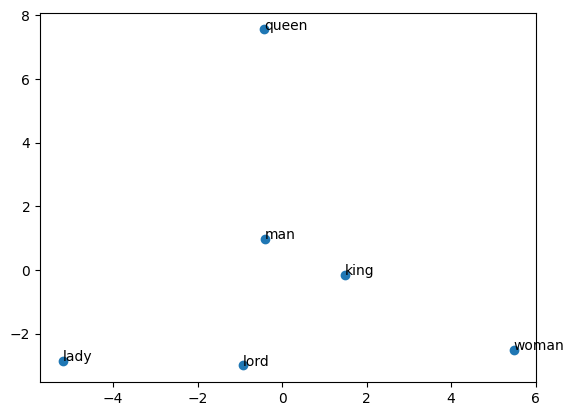

<Figure size 640x480 with 0 Axes>

In [28]:
# Plotting the vectors
# In order to plot and visualize the vectors in 2D, we can use an algorithm called *Principal Component Analysis (PCA)* 
# to reduce the vectors' dimensions from 50 (or whichever dimension we chose) down to 2.  This can be easily done using `sklearn`.  


# perform PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings_bef)

# plotting the 2D vectors
plt.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
plt.show()
#plt.savefig("plot.pdf") # save fig to pdf

### Word Vectors and Similarities Before Training

The plot below shows the 2D visualization of word vectors before training. The words included in this visualization are 'man', 'king', 'lord', 'woman', 'queen', and 'lady'. The positions of these words in the 2D space provide insight into their initial, randomly initialized relationships before the model has learned any meaningful semantic associations.


<div style='text-align:center;'><img src="images/plot_vectors_before_training.png"/></div>

### Hypotheses Verification After Training

To compare, after training, we expect the word vectors to exhibit the following changes:
- **Semantic Closeness**: Words with similar meanings, such as "king" and "queen" or "man" and "woman", should move closer together in the 2D space.
- **Distinct Clusters**: Words that belong to different semantic categories should form distinct clusters.
- **Improved Cosine Similarity**: Cosine similarity scores between semantically similar words should increase.


After training, a new plot can be generated to visualize how the word vectors have moved and whether the model has successfully learned the semantic relationships.


<Axes: >

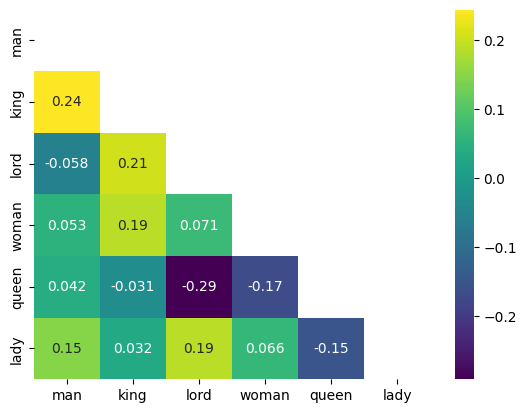

In [21]:
# This code creates a heatmap showing the cosine similarity between each of the words in the list

# compute cosine simil between words
dot_similarity = np.dot(embeddings_bef, embeddings_bef.T)
norms = np.linalg.norm(embeddings_bef, axis=1)
dot_similarity /= np.outer(norms, norms)

# create heatmap (top half has been masked for more clarity, since it shows the same scores as the bottom half)
mask = np.zeros_like(dot_similarity)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dot_similarity,
            xticklabels=words,
            yticklabels=words,
            annot=True,
            mask=mask,
            cmap='viridis')
# plt.savefig("heatmap.pdf") # save fig to pdf

### Cosine Similarities Before Training

The heatmap below shows the cosine similarities between word vectors before training. The words included are 'man', 'king', 'lord', 'woman', 'queen', and 'lady'. This visualization helps us understand the initial, randomly initialized relationships between the words before any training has occurred.



<div style='text-align:center;'><img src="images/heatmap_before_training.png"/></div>

#### Interpretation

- **Random Similarities**: The cosine similarities between the words are quite random, which is expected because the word vectors have not been trained and are initially random.
- **No Clear Patterns**: There are no clear patterns or clusters of similarity, as the vectors have not yet learned any meaningful relationships.

### Hypotheses Verification After Training

After training, we expect the following changes in the heatmap:
- **Increased Similarity for Related Words**: Words with similar meanings, such as "king" and "queen" or "man" and "woman", should show higher cosine similarity scores.
- **Decreased Similarity for Unrelated Words**: Words with different meanings should show lower cosine similarity scores.



#### 2.4 Training Loop

Start by selecting the appropriate loss function and optimizer.  Use `nn.CrossEntropyLoss()` as a loss function and `torch.optim.SGD`for the optimizer.  This optimizer is an implementation of the Gradient Descent algorithm and takes as arguments `model.parameters()`, the model's parameters, and `lr` the learning rate, which can be set to 0.1 when using batches of 128 (experiment with different values here). Next run the model for 150-200 epochs.

*NOTE: until you reset the parameters by re-instantiating the model, the training loop will continue from where it left off. If you stop and then retstart the cell below, you will continue training the parameters from the last epoch.*

In [23]:
import time
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 150

#TRAINING
# around 4s per epoch on my machine (small version)
# we can track the time passed per epoch by decommenting the time1 line and the print(time.time...) at the end.
for epoch in range(epochs):
    #time1 = time.time()
    
    # initiliaze the total_loss for each epoch to 0
    total_loss = 0.0

    # the dataloader is a generator object, it produces a batch of contexts and targets when we iterate over it.
    for context, target in dataloader:
        
        # get the logits
        logits = model(context)
        
        # calculate the loss by passing the logits and targets to the loss_function
        loss = loss_function(logits, target)
        
        # add the loss value to the total_loss (use loss.item() to get the value as a standard number vs a pytorch tensor)
        total_loss += loss.item()

        
        # optimize the network weights using the three steps seen in the XOR notebook
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # track the loss by printing it every 10 epochs (replace with 1 to see the time passed per epoch)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1} : {total_loss}')
    
    #print(time.time()-time1)

Epoch 10 : 5119.382235050201
Epoch 20 : 4900.065892696381
Epoch 30 : 4777.60112285614
Epoch 40 : 4688.539438724518
Epoch 50 : 4617.969173908234
Epoch 60 : 4558.839951753616
Epoch 70 : 4507.25491976738
Epoch 80 : 4461.066242456436
Epoch 90 : 4418.946729660034
Epoch 100 : 4379.988253116608
Epoch 110 : 4343.550120830536
Epoch 120 : 4309.175753116608
Epoch 130 : 4276.535244703293
Epoch 140 : 4245.3859095573425
Epoch 150 : 4215.544715166092


In [24]:
# save the trained model for easier experimentation
torch.save(model.state_dict(), f'cbow_model_{epochs}.pth') # add num of epochs to know which model this is for example

# load the trained model whenever we want with
model = CBOW(vocab_size, embedding_dim=50) # reset the model
model.load_state_dict(torch.load('cbow_model_150.pth')) # load the saved weights

<All keys matched successfully>

#### 2.5 Visualizing word vectors and similarities after training

Using the same list of words as before, the next cells show the new similarities and plot the new word vectors. 

Try changing the hyperparameters to see if they have any impact.  These include :

* number of embedding dimensions (ie. size of the embeddings)
* learning rate
* number of epochs
* batch size (optionally)

Training word vectors requires large amounts of text.  This project is a toy example, so do not be discouraged if differences are small... Try to still look for anything noteworthy.  

In [25]:
embeddings_aft = np.array([model.embeddings(torch.tensor(word2idx[word],dtype=torch.long)).detach().numpy() 
                       for word in words]).squeeze()

[-2.1022754  1.2793748]


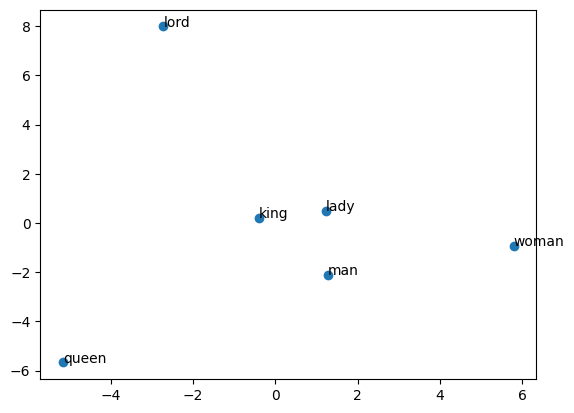

In [26]:
reduced = pca.fit_transform(embeddings_aft)
print(reduced[0])

plt.scatter(reduced[:,1], reduced[:, 0])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 1], reduced[i, 0]))
plt.show()
# plt.savefig("plot.pdf") # save fig to pdf

<Axes: >

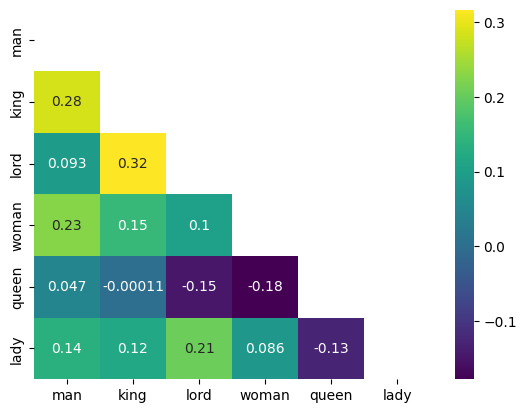

In [27]:
dot_similarity = np.dot(embeddings_aft, embeddings_aft.T)
norms = np.linalg.norm(embeddings_aft, axis=1)
dot_similarity /= np.outer(norms, norms)

mask = np.zeros_like(dot_similarity)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dot_similarity,
            xticklabels=words,
            yticklabels=words,
            annot=True,
            mask=mask,
            cmap='viridis')
# plt.savefig("heatmap.pdf") # save fig to pdf

### Visualizing Word Vectors and Similarities After Training

The plots below show the 2D visualization of word vectors and their cosine similarities after training. The words included in this visualization are 'man', 'king', 'lord', 'woman', 'queen', and 'lady'. These visualizations help us understand how the model has learned to represent the semantic relationships between these words.

#### PCA Plot of Word Vectors After Training

<div style='text-align:center;'><img src="images/plot_vectors_after_training.png"/></div>

#### Interpretation

- **Semantic Closeness**: Words like "king" and "queen" are closer together, indicating that the model has learned some semantic similarity between these words. Similarly, "man" and "woman" are also closer, showing that the model captures the gendered semantic relationships.
- **Distinct Clusters**: Words such as "king" and "queen" are relatively distinct from "man" and "woman", which aligns with their specific semantic roles in language (royalty vs. gender).
- **Improved Clustering**: The clustering of words now reflects meaningful semantic relationships, showing that the training has had a positive impact.

#### Cosine Similarity Heatmap After Training

<div style='text-align:center;'><img src="images/heatmap_after_training.png"/></div>

#### Interpretation

- **Increased Similarity for Related Words**: The cosine similarity scores between semantically similar words, such as "king" and "queen" or "man" and "woman", have increased, indicating that the model has learned to represent these relationships.
- **Decreased Similarity for Unrelated Words**: Words with different meanings show lower cosine similarity scores, reflecting their semantic differences.

### Hypotheses Verification

The results after training verify the hypotheses. Semantically similar words have moved closer together in the vector space, and their cosine similarity scores have increased. This suggests that the model has effectively captured some of the semantic relationships between these words.





### Summary
By adjusting these hyperparameters and potentially using a larger dataset, the word vectors can be further refined to better capture semantic similarities and differences, resulting in a more accurate representation of word meanings.